# Building a Sentiment Classifier using Scikit-Learn

Acknowledgement: This is derived from https://towardsdatascience.com/building-a-sentiment-classifier-using-scikit-learn-54c8e7c5d2f0. 

<center><img src="https://raw.githubusercontent.com/lazuxd/simple-imdb-sentiment-analysis/master/smiley.jpg"/></center>
<center><i>Image by AbsolutVision @ <a href="https://pixabay.com/ro/photos/smiley-emoticon-furie-sup%C4%83rat-2979107/">pixabay.com</a></i></center>

> &nbsp;&nbsp;&nbsp;&nbsp;**Sentiment analysis**, an important area in Natural Language Processing, is the process of automatically detecting affective states of text. Sentiment analysis is widely applied to voice-of-customer materials such as product reviews in online shopping websites like Amazon, movie reviews or social media. It can be just a basic task of classifying the polarity of a text as being positive/negative or it can go beyond polarity, looking at emotional states such as "happy", "angry", etc.

&nbsp;&nbsp;&nbsp;&nbsp;Here we will build a classifier that is able to distinguish movie reviews as being either positive or negative. For that, we will use [Large Movie Review Dataset v1.0](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)<sup>(2)</sup> of IMDB movie reviews.
This dataset contains 50,000 movie reviews divided evenly into 25k train and 25k test. The labels are balanced between the two classes (positive and negative). Reviews with a score <= 4 out of 10 are labeled negative and those with score >= 7 out of 10 are labeled positive. Neutral reviews are not included in the labeled data. This dataset also contains unlabeled reviews for unsupervised learning; we will not use them here. There are no more than 30 reviews for a particular movie because the ratings of the same movie tend to be correlated. All reviews for a given movie are either in train or test set but not in both, in order to avoid test accuracy gain by memorizing movie-specific terms.



## Data preprocessing

&nbsp;&nbsp;&nbsp;&nbsp;After the dataset has been downloaded and extracted from archive we have to transform it into a more suitable form for feeding it into a machine learning model for training. We will start by combining all review data into 2 pandas Data Frames representing the train and test datasets, and then saving them as csv files: *imdb_train.csv* and *imdb_test.csv*.  

&nbsp;&nbsp;&nbsp;&nbsp;The Data Frames will have the following form:  

|text       |label      |
|:---------:|:---------:|
|review1    |0          |
|review2    |1          |
|review3    |1          |
|.......    |...        |
|reviewN    |0          |  

&nbsp;&nbsp;&nbsp;&nbsp;where:  
- review1, review2, ... = the actual text of movie review  
- 0 = negative review  
- 1 = positive review

&nbsp;&nbsp;&nbsp;&nbsp;But machine learnng algorithms work only with numerical values. We can't just input the text itself into a machine learning model and have it learn from that. We have to, somehow, represent the text by numbers or vectors of numbers. One way of doing this is by using the **Bag-of-words** model<sup>(3)</sup>, in which a piece of text(often called a **document**) is represented by a vector of the counts of words from a vocabulary in that document. This model doesn't take into account grammar rules or word ordering; all it considers is the frequency of words. If we use the counts of each word independently we name this representation a **unigram**. In general, in a **n-gram** we take into account the counts of each combination of n words from the vocabulary that appears in a given document.  

&nbsp;&nbsp;&nbsp;&nbsp;For example, consider these two documents:  
<br>  
<div style="font-family: monospace;"><center><b>d1: "I am learning"&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</b></center></div>  
<div style="font-family: monospace;"><center><b>d2: "Machine learning is cool"</b></center></div>  
<br>
The vocabulary of all words encountered in these two sentences is: 

<br/>  
<div style="font-family: monospace;"><center><b>v: [ I, am, learning, machine, is, cool ]</b></center></div>   
<br>
&nbsp;&nbsp;&nbsp;&nbsp;The unigram representations of d1 and d2:  
<br>  

|unigram(d1)|I       |am      |learning|machine |is      |cool    |
|:---------:|:------:|:------:|:------:|:------:|:------:|:------:|
|           |1       |1       |1       |0       |0       |0       |  

|unigram(d2)|I       |am      |learning|machine |is      |cool    |
|:---------:|:------:|:------:|:------:|:------:|:------:|:------:|
|           |0       |0       |1       |1       |1       |1       |
  
&nbsp;&nbsp;&nbsp;&nbsp;And, the bigrams of d1 and d2 are:
  
|bigram(d1) |I I     |I am    |I learning|...|machine am|machine learning|...|cool is|cool cool|
|:---------:|:------:|:------:|:--------:|:-:|:--------:|:--------------:|:-:|:-----:|:-------:|
|           |0       |1       |0         |...|0         |0               |...|0      |0        |  

|bigram(d2) |I I     |I am    |I learning|...|machine am|machine learning|...|cool is|cool cool|
|:---------:|:------:|:------:|:--------:|:-:|:--------:|:--------------:|:-:|:-----:|:-------:|
|           |0       |0       |0         |...|0         |1               |...|0      |0        |

&nbsp;&nbsp;&nbsp;&nbsp;Often, we can achieve slightly better results if instead of counts of words we use something called **term frequency times inverse document frequency** (or **tf-idf**). Maybe it sounds complicated, but it is not. Bear with me, I will explain this. The intuition behind this is the following. So, what's the problem of using just the frequency of terms inside a document? Although some terms may have a high frequency inside documents they may not be so relevant for describing a given document in which they appear. That's because those terms may also have a high frequency across the collection of all documents. For example, a collection of movie reviews may have terms specific to movies/cinematography that are present in almost all documents(they have a high **document frequency**). So, when we encounter those terms in a document this doesn't tell much about whether it is a positive or negative review. We need a way of relating **term frequency** (how frequent a term is inside a document) to **document frequency** (how frequent a term is across the whole collection of documents). That is:  
  
$$\begin{align}\frac{\text{term frequency}}{\text{document frequency}} &= \text{term frequency} \cdot \frac{1}{\text{document frequency}} \\ &= \text{term frequency} \cdot \text{inverse document frequency} \\ &= \text{tf} \cdot \text{idf}\end{align}$$  
  
&nbsp;&nbsp;&nbsp;&nbsp;Now, there are more ways used to describe both term frequency and inverse document frequency. But the most common way is by putting them on a logarithmic scale:  
  
$$tf(t, d) = log(1+f_{t,d})$$  
$$idf(t) = log(\frac{1+N}{1+n_t})$$  
  
&nbsp;&nbsp;&nbsp;&nbsp;where:  
$$\begin{align}f_{t,d} &= \text{count of term } \textbf{t} \text{ in document } \textbf{d} \\  
N &= \text{total number of documents} \\  
n_t &= \text{number of documents that contain term } \textbf{t}\end{align}$$  
  
&nbsp;&nbsp;&nbsp;&nbsp;We added 1 in the first logarithm to avoid getting $-\infty$ when $f_{t,d}$ is 0. In the second logarithm we added one fake document to avoid division by zero.

&nbsp;&nbsp;&nbsp;&nbsp;Before we transform our data into vectors of counts or tf-idf values we should remove English **stopwords**<sup>(6)(7)</sup>. Stopwords are words that are very common in a language and are usually removed in the preprocessing stage of natural text-related tasks like sentiment analysis or search.

&nbsp;&nbsp;&nbsp;&nbsp;Note that we should construct our vocabulary only based on the training set. When we will process the test data in order to make predictions we should use only the vocabulary constructed in the training phase, the rest of the words will be ignored.

&nbsp;&nbsp;&nbsp;&nbsp;Now, let's create the data frames from the supplied csv files:

In [1]:
import pandas as pd

In [2]:
# Read in the training and test datasets from previously created csv files

imdb_train = pd.read_csv('csv/imdb_train.csv')
imdb_test = pd.read_csv('csv/imdb_test.csv')

In [3]:
# Display information and first few entries from the training and test datasets

pd.set_option('display.max_colwidth', None)

print ("----- Training dataset Info:")
imdb_train.info(verbose=None, buf=None, max_cols=None, memory_usage=None, null_counts=None)
print ("Training dataset Content:")
print(imdb_train.iloc[:5])

print ("\n----- Test dataset Info:")
imdb_test.info(verbose=None, buf=None, max_cols=None, memory_usage=None, null_counts=None)
print ("Test dataset Content:")
print(imdb_test.iloc[:5])


----- Training dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
Training dataset Content:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

### Text vectorization

&nbsp;&nbsp;&nbsp;&nbsp;Fortunately, for the text vectorization part all the hard work is already done in the Scikit-Learn classes `CountVectorizer`<sup>(8)</sup> and `TfidfTransformer`<sup>(5)</sup>. We will use these classes to transform our csv files into unigram and bigram matrices(using both counts and tf-idf values). (It turns out that if we only use a n-gram for a large n we don't get a good accuracy, we usually use all n-grams up to some n. So, when we say here bigrams we actually refer to uni+bigrams and when we say unigrams it's just unigrams.) Each row in those matrices will represent a document (review) in our dataset, and each column will represent values associated with each word in the vocabulary (in the case of unigrams) or values associated with each combination of maximum 2 words in the vocabulary (bigrams).  

&nbsp;&nbsp;&nbsp;&nbsp;`CountVectorizer` has a parameter `ngram_range` which expects a tuple of size 2 that controls what n-grams to include. After we constructed a `CountVectorizer` object we should call `.fit()` method with the actual text as a parameter, in order for it to learn the required statistics of our collection of documents. Then, by calling `.transform()` method with our collection of documents it returns the matrix for the n-gram range specified. As the class name suggests, this matrix will contain just the counts. To obtain the tf-idf values, the class `TfidfTransformer` should be used. It has the `.fit()` and `.transform()` methods that are used in a similar way with those of `CountVectorizer`, but they take as input the counts matrix obtained in the previous step and `.transform()` will return a matrix with tf-idf values. We should use `.fit()` only on training data and then store these objects. When we want to evaluate the test score or whenever we want to make a prediction we should use these objects to transform the data before feeding it into our classifier.  

&nbsp;&nbsp;&nbsp;&nbsp;Note that the matrices generated for our train or test data will be huge, and if we store them as normal numpy arrays they will not even fit into RAM. But most of the entries in these matrices will be zero. So, these Scikit-Learn classes are using Scipy sparse matrices<sup>(9)</sup> (`csr_matrix`<sup>(10)</sup> to be more exactly), which store just the non-zero entries and save a LOT of space.  

&nbsp;&nbsp;&nbsp;&nbsp;We will use a linear classifier with stochastic gradient descent, `sklearn.linear_model.SGDClassifier`<sup>(11)</sup>, as our model. First we will generate and save our data in 4 forms: unigram and bigram matrix (with both counts and tf-idf values for each). Then we will train and evaluate our model for each these 4 data representations using `SGDClassifier` with the default parameters. After that, we choose the data representation which led to the best score and we will tune the hyper-parameters of our model with this data form using cross-validation in order to obtain the best results.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#### Unigram Counts

In [5]:
# Create a unigram vectorizer and process the training set to generate a list of words. 
# Note that unigram processing is set via the ngram_range parameter

unigram_vectorizer = CountVectorizer(ngram_range=(1, 1))
unigram_vectorizer.fit(imdb_train['text'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [6]:
# Display the length and a few samples of the unigram vectorizer to show the words that have been extracted

print("Number of words found:", len(unigram_vectorizer.get_feature_names()))
print(unigram_vectorizer.get_feature_names()[10000:10100])
print(unigram_vectorizer.get_feature_names()[50000:50100])

Number of words found: 74849
['bête', 'bûsu', 'bürgermeister', 'c1', 'c3', 'c3p0', 'c3po', 'c4', 'c57', 'c__p', 'ca', 'caaaaaaaaaaaaaaaaaaaaaaligulaaaaaaaaaaaaaaaaaaaaaaa', 'caalling', 'caan', 'caas', 'cab', 'cabal', 'caballe', 'caballeros', 'caballo', 'cabals', 'cabana', 'cabanne', 'cabaret', 'cabarnet', 'cabbage', 'cabbages', 'cabbie', 'cabby', 'cabel', 'cabell', 'cabells', 'cabin', 'cabinet', 'cabinets', 'cabins', 'cabiria', 'cable', 'cables', 'cabo', 'cabot', 'cabrón', 'cabs', 'caca', 'caccia', 'cache', 'cachet', 'cacho', 'cack', 'cackle', 'cackles', 'cackling', 'caco', 'cacophonist', 'cacophonous', 'cacophony', 'cacoyanis', 'cacoyannis', 'cacti', 'cactus', 'cactuses', 'cad', 'cada', 'cadaver', 'cadaverous', 'cadavers', 'cadavra', 'cadby', 'caddie', 'caddy', 'caddyshack', 'cadena', 'cadence', 'cadences', 'cadet', 'cadets', 'cadfile', 'cadilac', 'cadillac', 'cadillacs', 'cadmus', 'cadre', 'cads', 'caduta', 'cady', 'caesar', 'caesars', 'caeser', 'caetano', 'cafe', 'cafes', 'cafeteria

In [7]:
# Now process the training dataset to get a count of the words extracted earlier

X_train_unigram = unigram_vectorizer.transform(imdb_train['text'].values)

In [8]:
# Display the attributes the word count matrix; notice it is huge with 25000 rows since we have 25000 entries
# in the training dataset and 74849 columns since we saw above that we have a vocabulary of 74849 words

print(repr(X_train_unigram))

<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>


#### Unigram Tf-Idf

In [9]:
# Create a unigram tf-idf vectorizer and load the training set using the word count matrix from earlier

unigram_tf_idf_transformer = TfidfTransformer()
unigram_tf_idf_transformer.fit(X_train_unigram)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [10]:
# Now calculate the unigram tf-idf statistics

X_train_unigram_tf_idf = unigram_tf_idf_transformer.transform(X_train_unigram)

In [11]:
# Display the attributes the unigram tf-idf matrix; it should be the same size as the unigram matrix above

print(repr(X_train_unigram_tf_idf))

<25000x74849 sparse matrix of type '<class 'numpy.float64'>'
	with 3431196 stored elements in Compressed Sparse Row format>


#### Bigram Counts

In [12]:
# Create a bigram vectorizer and process the training set to generate a list of bigrams. 
# Note that bigram processing is set via the ngram_range parameter and so includes unigrams and bigrams

bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))
bigram_vectorizer.fit(imdb_train['text'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [13]:
# Display the length and a few samples of the bigram vectorizer to show the bigrams that have been extracted

print("Number of bigrams found:", len(bigram_vectorizer.get_feature_names()))
print(bigram_vectorizer.get_feature_names()[10000:10100])
print(bigram_vectorizer.get_feature_names()[50000:50100])

Number of bigrams found: 1520266
['3am but', '3am invesment', '3am it', '3am taped', '3bs', '3bs who', '3d', '3d adventure', '3d although', '3d and', '3d animated', '3d animation', '3d animations', '3d animators', '3d artists', '3d assante', '3d bird', '3d bore', '3d capabilities', '3d cg', '3d cgi', '3d character', '3d companies', '3d computer', '3d dept', '3d disgrace', '3d effect', '3d effects', '3d element', '3d ending', '3d environment', '3d especially', '3d feel', '3d game', '3d games', '3d glasses', '3d grafics', '3d graphics', '3d gravity', '3d had', '3d imax', '3d in', '3d it', '3d just', '3d mario', '3d models', '3d movie', '3d movies', '3d panoramic', '3d plat', '3d probably', '3d programs', '3d sequence', '3d shoot', '3d shooter', '3d shooters', '3d special', '3d splatter', '3d technology', '3d that', '3d trust', '3d was', '3d wave', '3d well', '3d which', '3d with', '3d world', '3d wow', '3dvd', '3dvd collection', '3k', '3k all', '3k attack', '3k but', '3k if', '3k it', '3

In [14]:
# Now generate bigram statistics on the training set

X_train_bigram = bigram_vectorizer.transform(imdb_train['text'].values)

In [15]:
# Display the attributes the bigram count matrix; notice it is really huge with 25000 rows since we have 25000 entries
# in the training dataset and 1520266 columns since we saw above that we have 1520266 bigrams

print(repr(X_train_bigram))

<25000x1520266 sparse matrix of type '<class 'numpy.int64'>'
	with 8689547 stored elements in Compressed Sparse Row format>


#### Bigram Tf-Idf

In [16]:
# Create a bigram tf-idf vectorizer and load the training set using the bigram count matrix from earlier

bigram_tf_idf_transformer = TfidfTransformer()
bigram_tf_idf_transformer.fit(X_train_bigram)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [17]:
# Now calculate the bigram tf-idf statistics

X_train_bigram_tf_idf = bigram_tf_idf_transformer.transform(X_train_bigram)

In [18]:
# Display the attributes the bigram tf-idf matrix; it should be the same size as the bigram matrix above

print(repr(X_train_bigram_tf_idf))

<25000x1520266 sparse matrix of type '<class 'numpy.float64'>'
	with 8689547 stored elements in Compressed Sparse Row format>


### Try the four different data formats (unigram, bigram with and without tf_idf) on the training set and pick teh best

&nbsp;&nbsp;&nbsp;&nbsp;Now, for each data form we split it into train & validation sets, train a `SGDClassifier` and output the score.

In [19]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple

In [20]:
# Helper function to display confusion matrix

def display_confusion_matrix(y_true, y_pred) -> None:
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='coolwarm')
    plt.show()
    

In [21]:
def train_and_show_scores(X: csr_matrix, y: np.array, title: str) -> Tuple[float, float]:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.75, stratify=y
    )

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'{title}\nTrain score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}')
    
    train_pred = clf.predict(X_train)
    valid_pred = clf.predict(X_valid)
    print(f'Train precision: {round(precision_score(y_train, train_pred), 2)} ; Validation precision: {round(precision_score(y_valid, valid_pred), 2)}')
    print(f'Train recall: {round(recall_score(y_train, train_pred), 2)} ; Validation recall: {round(recall_score(y_valid, valid_pred), 2)}')
    print(f'Train F1: {round(f1_score(y_train, train_pred), 2)} ; Validation F1: {round(f1_score(y_valid, valid_pred), 2)}')
    print("Train Confusion Matrix: ")
    print(confusion_matrix(y_train, train_pred))
    display_confusion_matrix(y_train, train_pred)
    print("Validation Confusion Matrix: ")
    print(confusion_matrix(y_valid, valid_pred))
    display_confusion_matrix(y_valid, valid_pred)
    print("\n")
    
    return train_score, valid_score, clf

In [22]:
y_train = imdb_train['label'].values

----- Unigram Counts -----
Train score: 1.0 ; Validation score: 0.87
Train precision: 1.0 ; Validation precision: 0.87
Train recall: 1.0 ; Validation recall: 0.87
Train F1: 1.0 ; Validation F1: 0.87
Train Confusion Matrix: 
[[9369    6]
 [  13 9362]]


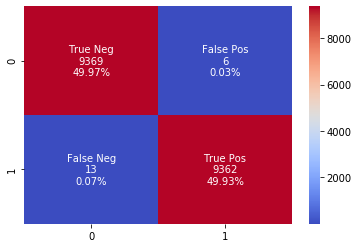

Validation Confusion Matrix: 
[[2721  404]
 [ 413 2712]]


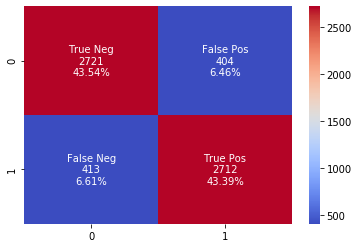



----- Unigram Tf-Idf -----
Train score: 0.95 ; Validation score: 0.89
Train precision: 0.95 ; Validation precision: 0.88
Train recall: 0.95 ; Validation recall: 0.89
Train F1: 0.95 ; Validation F1: 0.89
Train Confusion Matrix: 
[[8912  463]
 [ 454 8921]]


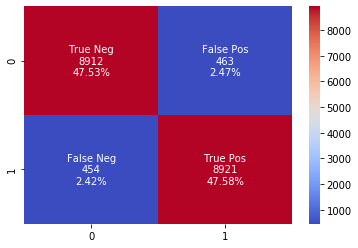

Validation Confusion Matrix: 
[[2760  365]
 [ 348 2777]]


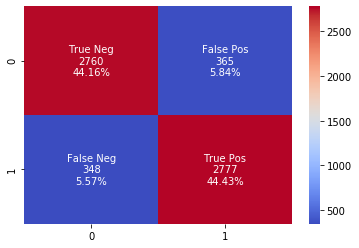



----- Bigram Counts -----
Train score: 1.0 ; Validation score: 0.87
Train precision: 0.99 ; Validation precision: 0.82
Train recall: 1.0 ; Validation recall: 0.94
Train F1: 1.0 ; Validation F1: 0.88
Train Confusion Matrix: 
[[9298   77]
 [   0 9375]]


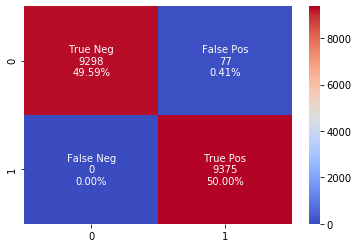

Validation Confusion Matrix: 
[[2492  633]
 [ 176 2949]]


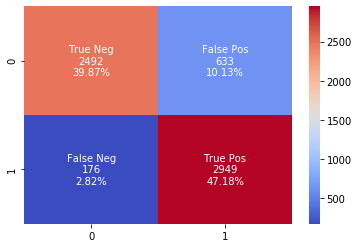



----- Bigram Tf-Idf -----
Train score: 0.98 ; Validation score: 0.9
Train precision: 0.98 ; Validation precision: 0.89
Train recall: 0.98 ; Validation recall: 0.92
Train F1: 0.98 ; Validation F1: 0.9
Train Confusion Matrix: 
[[9163  212]
 [ 179 9196]]


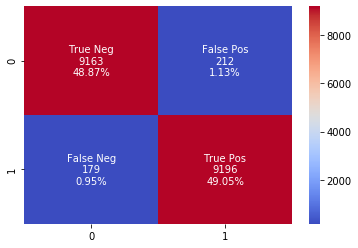

Validation Confusion Matrix: 
[[2753  372]
 [ 259 2866]]


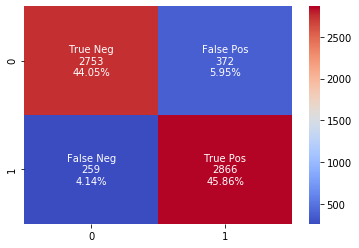

In [23]:
uc_train_score, uc_valid_score, uc_clf = train_and_show_scores(X_train_unigram, y_train, '----- Unigram Counts -----')
utfidf_train_score, utfidf_valid_score, utfidf_clf = train_and_show_scores(X_train_unigram_tf_idf, y_train, '----- Unigram Tf-Idf -----')
bc_train_score, bc_valid_score, bc_clf = train_and_show_scores(X_train_bigram, y_train, '----- Bigram Counts -----')
btfidf_train_score, btfidf_valid_score, btfidf_clf = train_and_show_scores(X_train_bigram_tf_idf, y_train, '----- Bigram Tf-Idf -----')

Training score for the four approaches:


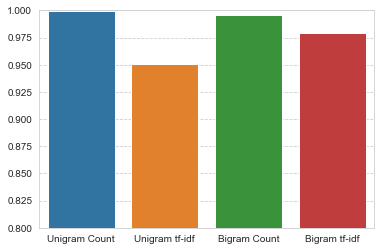

Validation score for the four approaches:


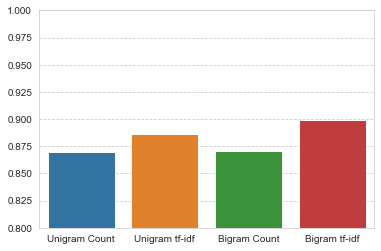

In [24]:
# Display the previously derived scores for the four scenarios

sns.set_style("whitegrid", {'grid.linestyle': '--'})

print ("Training score for the four approaches:")
ax1 = sns.barplot(
    x= ['Unigram Count', 'Unigram tf-idf', 'Bigram Count', 'Bigram tf-idf'],
    y= [uc_train_score, utfidf_train_score, bc_train_score, btfidf_train_score])
ax1.set(ylim=(0.8, 1.0))
plt.show()

print ("Validation score for the four approaches:")
ax2 = sns.barplot(
    x= ['Unigram Count', 'Unigram tf-idf', 'Bigram Count', 'Bigram tf-idf'],
    y= [uc_valid_score, utfidf_valid_score, bc_valid_score, btfidf_valid_score])
ax2.set(ylim=(0.8, 1.0))
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;The best data form seems to be **bigram with tf-idf** as it gets the highest validation accuracy: **0.9**; so we will choose it as our preferred approach.

### Testing model

In [25]:
# Transform the test data set into the bigram tf-idf format

X_test = bigram_vectorizer.transform(imdb_test['text'].values)
X_test = bigram_tf_idf_transformer.transform(X_test)
y_test = imdb_test['label'].values

Score: 0.8934
Test precision: 0.8847
Test recall: 0.9047
Test F1: 0.8946
Test Confusion Matrix: 
[[11026  1474]
 [ 1191 11309]]


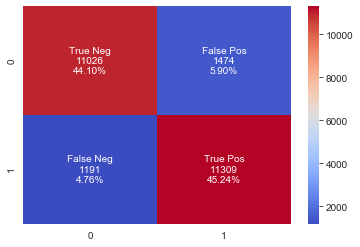

In [26]:
# Now evaluate the test data using the previously trained bigram tf-idf classifier

clf = btfidf_clf
score = clf.score(X_test, y_test)

print(f'Score: {round(score, 4)}')

test_pred = clf.predict(X_test)
print(f'Test precision: {round(precision_score(y_test, test_pred), 4)}')
print(f'Test recall: {round(recall_score(y_test, test_pred), 4)}')
print(f'Test F1: {round(f1_score(y_test, test_pred), 4)}')
print("Test Confusion Matrix: ")
print(confusion_matrix(y_test, test_pred))
display_confusion_matrix(y_test, test_pred)
print("\n")

----- Bigram Counts -----
Train score: 1.0 ; Validation score: 0.89
Train precision: 1.0 ; Validation precision: 0.89
Train recall: 1.0 ; Validation recall: 0.89
Train F1: 1.0 ; Validation F1: 0.89
Train Confusion Matrix: 
[[9375    0]
 [   0 9375]]


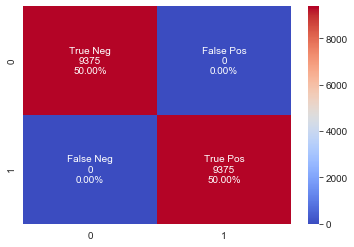

Validation Confusion Matrix: 
[[2777  348]
 [ 331 2794]]


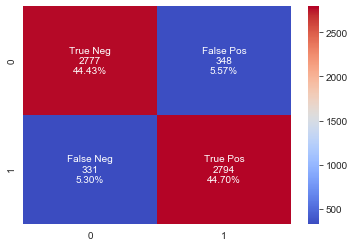



----- Bigram Tf-Idf -----
Train score: 1.0 ; Validation score: 0.91
Train precision: 1.0 ; Validation precision: 0.91
Train recall: 1.0 ; Validation recall: 0.91
Train F1: 1.0 ; Validation F1: 0.91
Train Confusion Matrix: 
[[9372    3]
 [   7 9368]]


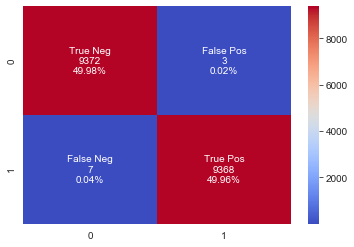

Validation Confusion Matrix: 
[[2829  296]
 [ 271 2854]]


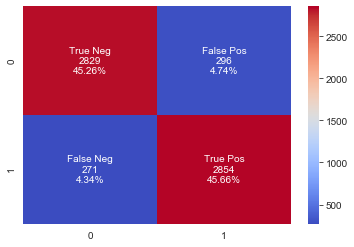



----- Unigram Counts -----
Train score: 0.99 ; Validation score: 0.88
Train precision: 1.0 ; Validation precision: 0.87
Train recall: 0.99 ; Validation recall: 0.89
Train F1: 0.99 ; Validation F1: 0.88
Train Confusion Matrix: 
[[9330   45]
 [  51 9324]]


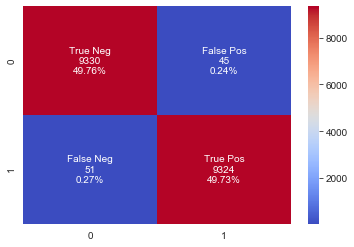

Validation Confusion Matrix: 
[[2719  406]
 [ 345 2780]]


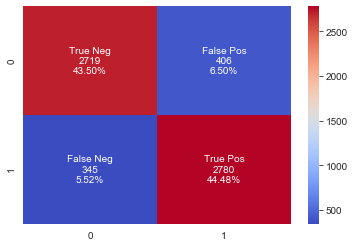

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


----- Unigram Tf-Idf -----
Train score: 0.82 ; Validation score: 0.79
Train precision: 0.86 ; Validation precision: 0.83
Train recall: 0.75 ; Validation recall: 0.72
Train F1: 0.81 ; Validation F1: 0.77
Train Confusion Matrix: 
[[8249 1126]
 [2300 7075]]


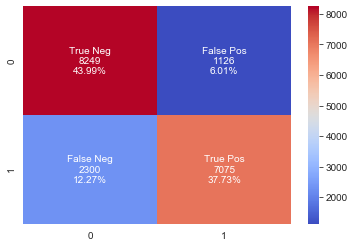

Validation Confusion Matrix: 
[[2673  452]
 [ 885 2240]]


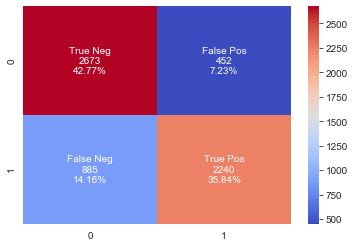



----- Trigram Counts -----
Train score: 1.0 ; Validation score: 0.81
Train precision: 1.0 ; Validation precision: 0.78
Train recall: 1.0 ; Validation recall: 0.87
Train F1: 1.0 ; Validation F1: 0.82
Train Confusion Matrix: 
[[9364   11]
 [   0 9375]]


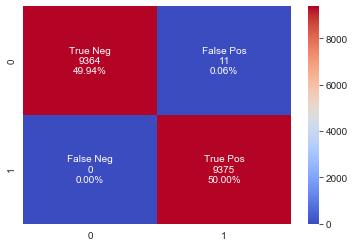

Validation Confusion Matrix: 
[[2350  775]
 [ 406 2719]]


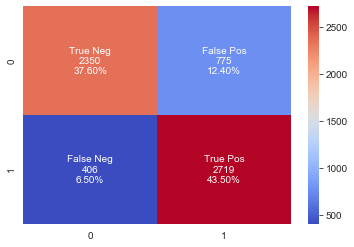



----- Trigram Tf-Idf -----
Train score: 1.0 ; Validation score: 0.85
Train precision: 1.0 ; Validation precision: 0.82
Train recall: 1.0 ; Validation recall: 0.9
Train F1: 1.0 ; Validation F1: 0.86
Train Confusion Matrix: 
[[9375    0]
 [   0 9375]]


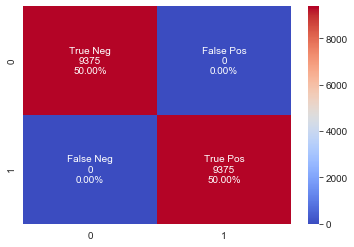

Validation Confusion Matrix: 
[[2514  611]
 [ 321 2804]]


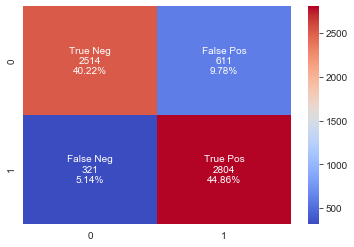



Training score for the six approaches:


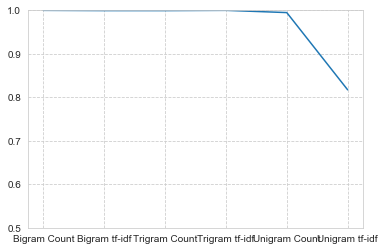

Validation score for the four approaches:


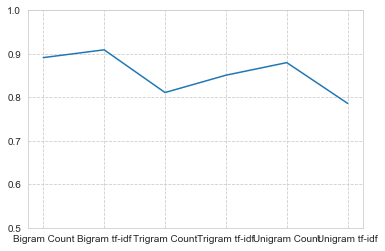

In [37]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

def display_confusion_matrix(y_true, y_pred) -> None:
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='coolwarm')
    plt.show()

def new_train_and_show_scores(X: csr_matrix, y: np.array, title: str) -> Tuple[float, float]:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, train_size=0.75, stratify=y
    )

    clf = SGDClassifier(loss="squared_hinge",penalty="l2",learning_rate="optimal")
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)
    print(f'{title}\nTrain score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}')
    
    train_pred = clf.predict(X_train)
    valid_pred = clf.predict(X_valid)
    print(f'Train precision: {round(precision_score(y_train, train_pred), 2)} ; Validation precision: {round(precision_score(y_valid, valid_pred), 2)}')
    print(f'Train recall: {round(recall_score(y_train, train_pred), 2)} ; Validation recall: {round(recall_score(y_valid, valid_pred), 2)}')
    print(f'Train F1: {round(f1_score(y_train, train_pred), 2)} ; Validation F1: {round(f1_score(y_valid, valid_pred), 2)}')
    print("Train Confusion Matrix: ")
    print(confusion_matrix(y_train, train_pred))
    display_confusion_matrix(y_train, train_pred)
    print("Validation Confusion Matrix: ")
    print(confusion_matrix(y_valid, valid_pred))
    display_confusion_matrix(y_valid, valid_pred)
    print("\n")
    
    return train_score, valid_score, clf

imdb_train = pd.read_csv('csv/imdb_train.csv')
corpus = imdb_train['text'].values

trigram_tf_idf_transformer = TfidfTransformer()
trigram_tf_idf_transformer.fit(vectorizer3.transform(corpus))

vectorizer3 = CountVectorizer(analyzer='word', ngram_range=(3, 3)) 
vectorizer3.fit_transform(corpus)
vectorizer4 = CountVectorizer(analyzer='word', ngram_range=(3, 3), stop_words= stopwords.words('english'))
vectorizer4.fit_transform(corpus)


X_train_trigram_tf_idf = trigram_tf_idf_transformer.transform(vectorizer3.transform(corpus))
# X_train_trigram_tf_idf.fit()
# bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))
# bigram_vectorizer.fit(imdb_train['text'].values)
# X_train_bigram_tf_idf = TfidfTransformer().transform(bigram_vectorizer.transform(imdb_train['text'].values))
    
bc_train_score, bc_valid_score, bc_clf = new_train_and_show_scores(X_train_bigram, y_train, '----- Bigram Counts -----')
btfidf_train_score, btfidf_valid_score, btfidf_clf = new_train_and_show_scores(X_train_bigram_tf_idf, y_train, '----- Bigram Tf-Idf -----')

uc_train_score, uc_valid_score, uc_clf = new_train_and_show_scores(X_train_unigram, y_train, '----- Unigram Counts -----')
utfidf_train_score, utfidf_valid_score, utfidf_clf = new_train_and_show_scores(X_train_unigram_tf_idf, y_train, '----- Unigram Tf-Idf -----')

tc_train_score, tc_valid_score, tc_clf = new_train_and_show_scores(X3, y_train, '----- Trigram Counts -----')
ttfidf_train_score, ttfidf_valid_score, ttfidf_clf = new_train_and_show_scores(X_train_trigram_tf_idf, y_train, '----- Trigram Tf-Idf -----')


print ("Training score for the six approaches:")
ax1 = sns.lineplot(
    x= ['Unigram Count', 'Unigram tf-idf', 'Bigram Count', 'Bigram tf-idf', 'Trigram Count',  'Trigram tf-idf'],
    y= [uc_train_score, utfidf_train_score, bc_train_score, btfidf_train_score, tc_train_score,  ttfidf_train_score])
ax1.set(ylim=(0.50, 1.00))
plt.show()

print ("Validation score for the six approaches:")
ax2 = sns.lineplot(
    x= ['Unigram Count', 'Unigram tf-idf', 'Bigram Count', 'Bigram tf-idf', 'Trigram Count',  'Trigram tf-idf'],
    y= [uc_valid_score, utfidf_valid_score, bc_valid_score, btfidf_valid_score,  tc_valid_score,  ttfidf_valid_score])
ax2.set(ylim=(0.50, 1.00))
plt.show()

&nbsp;&nbsp;&nbsp;&nbsp;And we got almost 90% test accuracy. That's not bad for our simple linear model. There are more advanced methods that give better results. The current state-of-the-art on this dataset is **97.42%** <sup>(13)</sup>

## References

<sup>(1)</sup> &nbsp;[Sentiment Analysis - Wikipedia](https://en.wikipedia.org/wiki/Sentiment_analysis)  
<sup>(2)</sup> &nbsp;[Learning Word Vectors for Sentiment Analysis](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf)  
<sup>(3)</sup> &nbsp;[Bag-of-words model - Wikipedia](https://en.wikipedia.org/wiki/Bag-of-words_model)  
<sup>(4)</sup> &nbsp;[Tf-idf - Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)  
<sup>(5)</sup> &nbsp;[TfidfTransformer - Scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)  
<sup>(6)</sup> &nbsp;[Stop words - Wikipedia](https://en.wikipedia.org/wiki/Stop_words)  
<sup>(7)</sup> &nbsp;[A list of English stopwords](https://gist.github.com/sebleier/554280)  
<sup>(8)</sup> &nbsp;[CountVectorizer - Scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)  
<sup>(9)</sup> &nbsp;[Scipy sparse matrices](https://docs.scipy.org/doc/scipy/reference/sparse.html)  
<sup>(10)</sup> [Compressed Sparse Row matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix)  
<sup>(11)</sup> [SGDClassifier - Scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)  
<sup>(12)</sup> [RandomizedSearchCV - Scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)  
<sup>(13)</sup> [Sentiment Classification using Document Embeddings trained with
Cosine Similarity](https://www.aclweb.org/anthology/P19-2057.pdf)  